In [1]:
from pyspark.sql import SparkSession

In [2]:
app = SparkSession.builder.appName('flights').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/03 22:35:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/03 22:35:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
app

In [7]:
df = app.read.csv('flights-larger.csv',header=True, inferSchema=True)

In [8]:
df.show(5)

+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102|   NA|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



In [9]:
df.count()

275000

Data columns:

mon — month (int between 1 and 12)

dom — day of month (int between 1 and 31)

dow — day of week (int; 1 = Monday and 7 = Sunday)

org — origin airport (str; IATA code)

mile — distance (int; miles)

carrier — carrier (str; IATA code)

depart — departure time (int; decimal hour)

duration — expected duration (int; minutes)

delay — delay (int; minutes)

(IATA -> International Air Transport Association)

In [10]:
df.dtypes

[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('mile', 'int'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'string')]

In [11]:
df = df.dropna()

In [12]:
df = df.withColumnRenamed("mon", "month")


In [13]:
df.show(5)

+-----+---+---+-------+------+---+----+------+--------+-----+
|month|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+-----+---+---+-------+------+---+----+------+--------+-----+
|   10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|
|    1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102|   NA|
|   11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|
|    2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|
|    5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|
+-----+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



In [14]:
unique_count = df.select("carrier").distinct().count()
print("Count of Unique Values:", unique_count)

Count of Unique Values: 9


In [15]:
unique_org = df.select("org").distinct().count()
print("Count of Unique Values:", unique_org)

Count of Unique Values: 8


In [16]:
df = df.dropna()

In [17]:
df=  df.drop('flight')

df.show(5)

+-----+---+---+-------+---+----+------+--------+-----+
|month|dom|dow|carrier|org|mile|depart|duration|delay|
+-----+---+---+-------+---+----+------+--------+-----+
|   10| 10|  1|     OO|ORD| 157|  8.18|      51|   27|
|    1|  4|  1|     OO|ORD| 466|  15.5|     102|   NA|
|   11| 22|  1|     OO|ORD| 738|  7.17|     127|  -19|
|    2| 14|  5|     B6|JFK|2248| 21.17|     365|   60|
|    5| 25|  3|     WN|SJC| 386| 12.92|      85|   22|
+-----+---+---+-------+---+----+------+--------+-----+
only showing top 5 rows



In [18]:
from pyspark.sql.functions import isnan, when, count, col
missing_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

# Show the missing value counts
missing_counts.show()

+-----+---+---+-------+---+----+------+--------+-----+
|month|dom|dow|carrier|org|mile|depart|duration|delay|
+-----+---+---+-------+---+----+------+--------+-----+
|    0|  0|  0|      0|  0|   0|     0|       0|    0|
+-----+---+---+-------+---+----+------+--------+-----+



In [19]:
from pyspark.sql.functions import round
df= df.withColumn('km', round(df.mile * 1.60934, 0)).drop('mile')


In [20]:
column_name = "delay"
df = df.withColumn(column_name, when(col(column_name) == "NA", 0).otherwise(col(column_name)))

In [21]:
df.show(5)

+-----+---+---+-------+---+------+--------+-----+------+
|month|dom|dow|carrier|org|depart|duration|delay|    km|
+-----+---+---+-------+---+------+--------+-----+------+
|   10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|
|    1|  4|  1|     OO|ORD|  15.5|     102|    0| 750.0|
|   11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|
|    2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|
|    5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|
+-----+---+---+-------+---+------+--------+-----+------+
only showing top 5 rows



In [22]:
df = df.withColumn('label', (df.delay >= 15).cast('integer'))


In [23]:
df.show(5)

+-----+---+---+-------+---+------+--------+-----+------+-----+
|month|dom|dow|carrier|org|depart|duration|delay|    km|label|
+-----+---+---+-------+---+------+--------+-----+------+-----+
|   10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|
|    1|  4|  1|     OO|ORD|  15.5|     102|    0| 750.0|    0|
|   11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|
|    2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|
|    5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|
+-----+---+---+-------+---+------+--------+-----+------+-----+
only showing top 5 rows



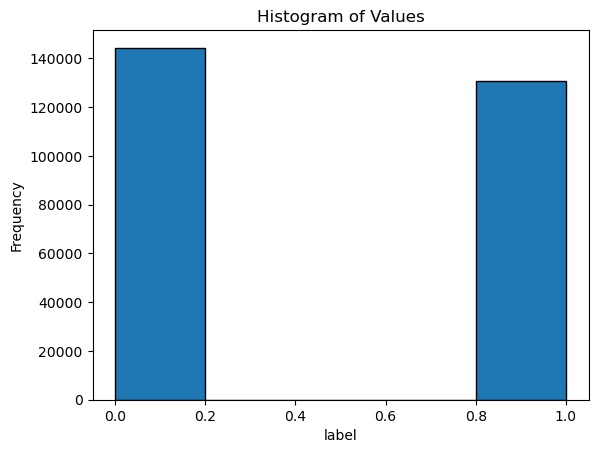

In [24]:
import matplotlib.pyplot as plt

values = df.select("label").rdd.flatMap(lambda x: x).collect()

plt.hist(values, bins=5, edgecolor="black")
plt.xlabel("label")
plt.ylabel("Frequency")
plt.title("Histogram of Values")
plt.show()

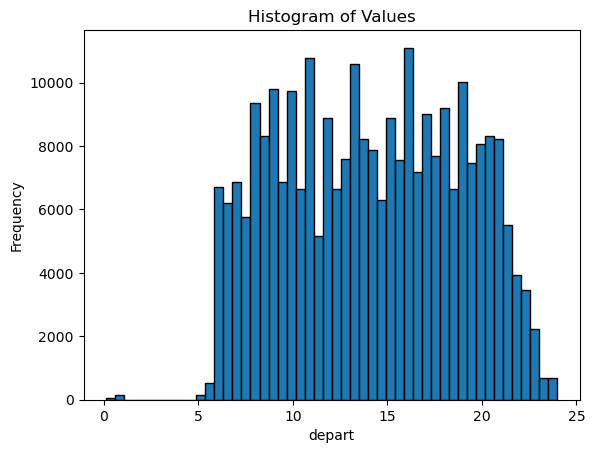

In [25]:
v = df.select('depart').rdd.flatMap(lambda x : x).collect()

plt.hist(v, bins=50, edgecolor="black")
plt.xlabel("depart")
plt.ylabel("Frequency")
plt.title("Histogram of Values")
plt.show()

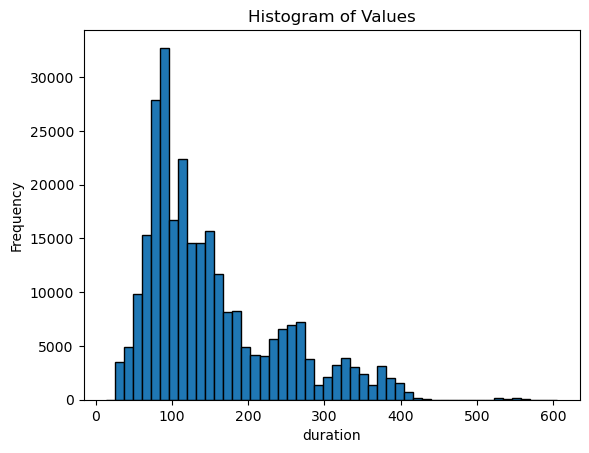

In [26]:
duration = df.select('duration').rdd.flatMap(lambda x:x).collect()

plt.hist(duration, bins=50, edgecolor='black')
plt.xlabel('duration')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [27]:
from pyspark.sql.functions import col, when, isnull
df = df.withColumn(
    'delay_type',
    when(isnull(col('delay')), 'Unknown')
    .when(col('delay') < 15, 'Minor Delay')
    .when(col('delay') < 30, 'Moderate Delay')
    .when(col('delay') < 60, 'Significant Delay')
    .when(col('delay') < 180, 'Major Delay')
    .otherwise('Severe Delay')
)

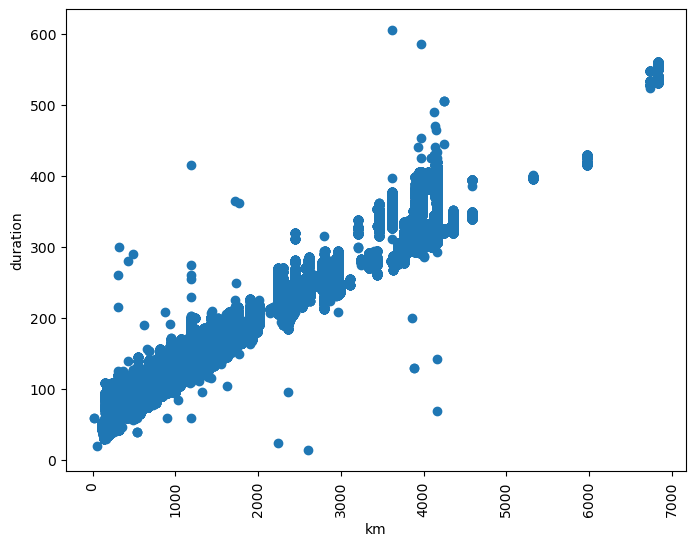

In [28]:
km = df.select('km').rdd.flatMap(lambda x :x).collect()
plt.figure(figsize=(8, 6))
plt.scatter(km,duration)
plt.xlabel('km')
plt.ylabel('duration')
plt.xticks(rotation=90)
plt.show()

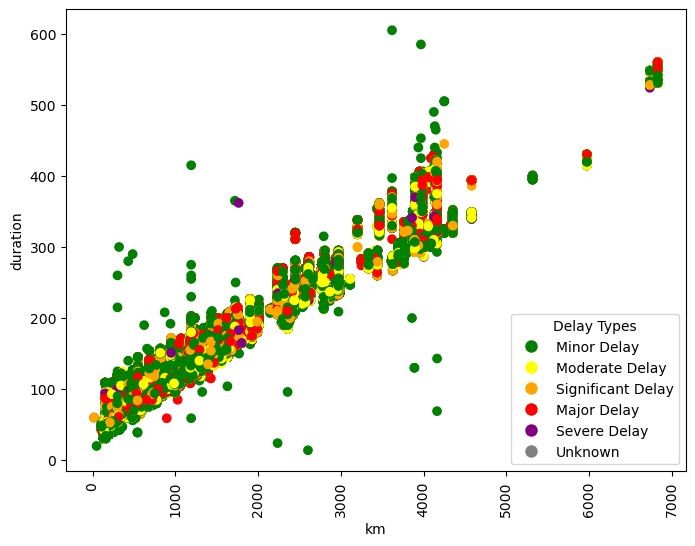

In [29]:
import pandas as pd

km = df.select('km').rdd.flatMap(lambda x: x).collect()
duration = df.select('duration').rdd.flatMap(lambda x: x).collect()

delay_type = df.select('delay_type').rdd.flatMap(lambda x: x).collect()

color_mapping = {
    'Minor Delay': 'green',
    'Moderate Delay': 'yellow',
    'Significant Delay': 'orange',
    'Major Delay': 'red',
    'Severe Delay': 'purple',
    'Unknown': 'gray'  
}

colors = [color_mapping.get(dt, 'gray') for dt in delay_type]

plt.figure(figsize=(8, 6))
plt.scatter(km, duration, c=colors)  # Use the colors parameter
plt.xlabel('km')
plt.ylabel('duration')
plt.xticks(rotation=90)

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                 for label, color in color_mapping.items()]
plt.legend(handles=legend_labels, title='Delay Types')

plt.show()


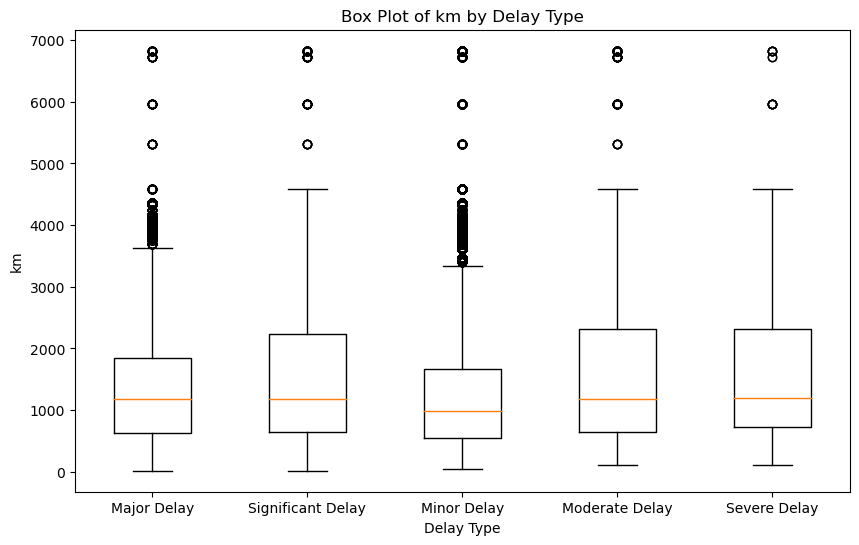

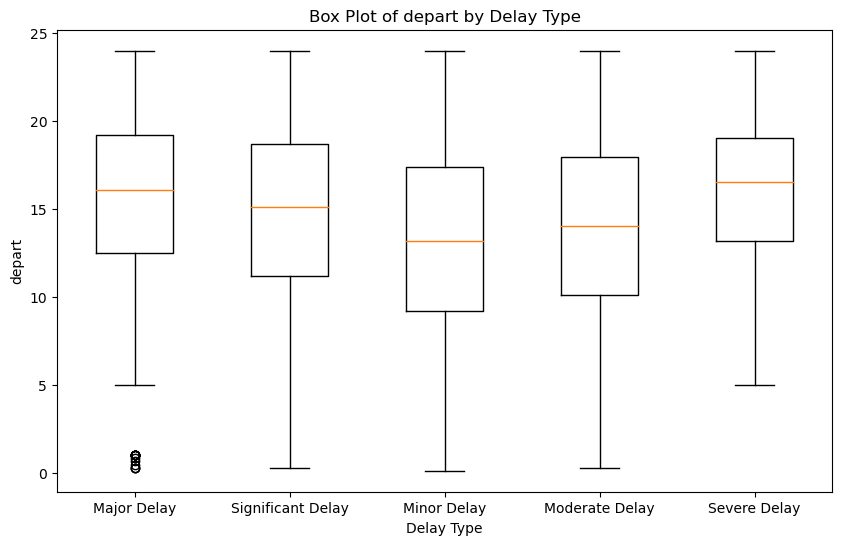

In [30]:
unique_delay_types = df.select('delay_type').distinct().rdd.flatMap(lambda x: x).collect()

km_values_by_delay_type = {delay_type: [] for delay_type in unique_delay_types}

filter_data = ['km', 'depart']  # List of columns to filter

for fil in filter_data:
    km_values_by_delay_type = {delay_type: [] for delay_type in unique_delay_types}
    
    for delay_type in unique_delay_types:
        filtered_df = df.filter(df['delay_type'] == delay_type)
        km_values = filtered_df.select(fil).rdd.flatMap(lambda x: x).collect()
        km_values_by_delay_type[delay_type] = km_values

    km_data = [km_values_by_delay_type[delay_type] for delay_type in unique_delay_types]

    plt.figure(figsize=(10, 6))
    plt.boxplot(km_data, labels=unique_delay_types)
    plt.title(f'Box Plot of {fil} by Delay Type')
    plt.xlabel('Delay Type')
    plt.ylabel(fil)
    plt.show()


In [31]:
from pyspark.ml.feature import StringIndexer
flights_indexed = StringIndexer(inputCol='carrier', outputCol='carrier_idx').fit(df).transform(df)

flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)

In [32]:
flights_indexed.show(5)

+-----+---+---+-------+---+------+--------+-----+------+-----+--------------+-----------+-------+
|month|dom|dow|carrier|org|depart|duration|delay|    km|label|    delay_type|carrier_idx|org_idx|
+-----+---+---+-------+---+------+--------+-----+------+-----+--------------+-----------+-------+
|   10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|Moderate Delay|        2.0|    0.0|
|    1|  4|  1|     OO|ORD|  15.5|     102|    0| 750.0|    0|   Minor Delay|        2.0|    0.0|
|   11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|   Minor Delay|        2.0|    0.0|
|    2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|   Major Delay|        4.0|    2.0|
|    5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|Moderate Delay|        3.0|    5.0|
+-----+---+---+-------+---+------+--------+-----+------+-----+--------------+-----------+-------+
only showing top 5 rows



In [33]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['month', 'dom', 'dow',
'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')
flights_assembled = assembler.transform(flights_indexed)
flights_assembled.select('features', 'delay').show(5, truncate=False)

+-----------------------------------------+-----+
|features                                 |delay|
+-----------------------------------------+-----+
|[10.0,10.0,1.0,2.0,0.0,253.0,8.18,51.0]  |27   |
|[1.0,4.0,1.0,2.0,0.0,750.0,15.5,102.0]   |0    |
|[11.0,22.0,1.0,2.0,0.0,1188.0,7.17,127.0]|-19  |
|[2.0,14.0,5.0,4.0,2.0,3618.0,21.17,365.0]|60   |
|[5.0,25.0,3.0,3.0,5.0,621.0,12.92,85.0]  |22   |
+-----------------------------------------+-----+
only showing top 5 rows



In [34]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [35]:
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=42)

In [36]:
tree = DecisionTreeClassifier()

model = tree.fit(flights_train)

In [37]:
pred = model.transform(flights_test)

In [38]:
pred.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |1.0       |[0.37844226007353493,0.6215577399264651]|
|1    |1.0       |[0.49025247682965806,0.509747523170342] |
|1    |0.0       |[0.6043459552495697,0.3956540447504303] |
|0    |1.0       |[0.37844226007353493,0.6215577399264651]|
|1    |1.0       |[0.37844226007353493,0.6215577399264651]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [39]:
pred.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = pred.filter('prediction = 0 AND label = prediction').count()
TP = pred.filter('prediction = 1 AND label = prediction').count()
FN = pred.filter('prediction = 0 AND label != prediction').count()
FP = pred.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9294|
|    0|       0.0|16844|
|    1|       1.0|16865|
|    0|       1.0|12045|
+-----+----------+-----+



0.6123564888824299
